# Support Vector Regression (SVR) for Retail Inventory Forecasting  
Complete end-to-end pipeline with interpretability

## 1. Import Libraries & Global Setup

In [ ]:
"""
Support Vector Regression (SVR) for Retail Inventory Forecasting
Complete end-to-end pipeline with interpretability
"""

# ============================================================================
# 1. IMPORT LIBRARIES
# ============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import shap

from datetime import datetime
import joblib

from google.colab import drive
drive.mount('/content/drive/')

# Set random seed for reproducibility
np.random.seed(42)

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("="*80)
print("SVR-BASED RETAIL INVENTORY FORECASTING SYSTEM")
print("="*80)

SVR-BASED RETAIL INVENTORY FORECASTING SYSTEM


## 2. Data Loading

In [ ]:
# ============================================================================
# 2. DATA LOADING
# ============================================================================
print("\n[STEP 1] Loading Data...")
df = pd.read_csv('/content/drive/MyDrive/data/retail_store_inventory.csv')
print(f"Dataset loaded successfully: {df.shape[0]} rows, {df.shape[1]} columns")
print(f"\nFirst few rows:\n{df.head()}")
print(f"\nData types:\n{df.dtypes}")
print(f"\nBasic statistics:\n{df.describe()}")


[STEP 1] Loading Data...
Dataset loaded successfully: 73100 rows, 15 columns

First few rows:
         Date Store ID Product ID     Category Region  Inventory Level  \
0  2022-01-01     S001      P0001    Groceries  North              231   
1  2022-01-01     S001      P0002         Toys  South              204   
2  2022-01-01     S001      P0003         Toys   West              102   
3  2022-01-01     S001      P0004         Toys  North              469   
4  2022-01-01     S001      P0005  Electronics   East              166   

   Units Sold  Units Ordered  Demand Forecast  Price  Discount  \
0         127             55           135.47  33.50        20   
1         150             66           144.04  63.01        20   
2          65             51            74.02  27.99        10   
3          61            164            62.18  32.72        10   
4          14            135             9.26  73.64         0   

  Weather Condition  Holiday/Promotion  Competitor Pricing Seas

## 3. Data Preprocessing

In [ ]:
# ============================================================================
# 3. DATA PREPROCESSING
# ============================================================================
print("\n" + "="*80)
print("[STEP 2] Data Preprocessing")
print("="*80)

# Check for missing values
print("\nMissing values before cleaning:")
print(df.isnull().sum())

# Handle date column (assuming there's a date column)
date_columns = df.select_dtypes(include=['object']).columns
for col in date_columns:
    try:
        df[col] = pd.to_datetime(df[col])
        print(f"Converted {col} to datetime")
        break
    except:
        continue

# If date column exists, sort by date
if 'date' in df.columns.str.lower():
    date_col = [col for col in df.columns if 'date' in col.lower()][0]
    df = df.sort_values(by=date_col).reset_index(drop=True)
    print(f"Data sorted by {date_col}")

# Fill missing values
numeric_cols = df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].median(), inplace=True)
        print(f"Filled missing values in {col} with median")

categorical_cols = df.select_dtypes(include=['object', 'category']).columns
for col in categorical_cols:
    if col not in [date_col] if 'date_col' in locals() else True:
        if df[col].isnull().sum() > 0:
            df[col].fillna(df[col].mode()[0], inplace=True)
            print(f"Filled missing values in {col} with mode")

# Handle outliers using IQR method
def remove_outliers_iqr(df, column, multiplier=1.5):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Identify target variable (likely 'sales' or 'inventory' or 'quantity')
target_candidates = ['sales', 'inventory', 'quantity', 'demand', 'units_sold']
target_col = None
for col in target_candidates:
    if col in df.columns.str.lower():
        target_col = [c for c in df.columns if c.lower() == col][0]
        break

if target_col is None:
    # Use first numeric column as target
    target_col = numeric_cols[0]

print(f"\nTarget variable identified: {target_col}")

# Remove outliers from target
original_size = len(df)
df = remove_outliers_iqr(df, target_col, multiplier=2.0)
print(f"Outliers removed: {original_size - len(df)} records")

print(f"\nMissing values after cleaning:\n{df.isnull().sum().sum()} total missing values")


[STEP 2] Data Preprocessing

Missing values before cleaning:
Date                  0
Store ID              0
Product ID            0
Category              0
Region                0
Inventory Level       0
Units Sold            0
Units Ordered         0
Demand Forecast       0
Price                 0
Discount              0
Weather Condition     0
Holiday/Promotion     0
Competitor Pricing    0
Seasonality           0
dtype: int64
Converted Date to datetime
Data sorted by Date

Target variable identified: Inventory Level
Outliers removed: 0 records

Missing values after cleaning:
0 total missing values


## 4. Exploratory Data Analysis (EDA)


[STEP 3] Exploratory Data Analysis

EDA plots saved as 'svr_eda_analysis.png'


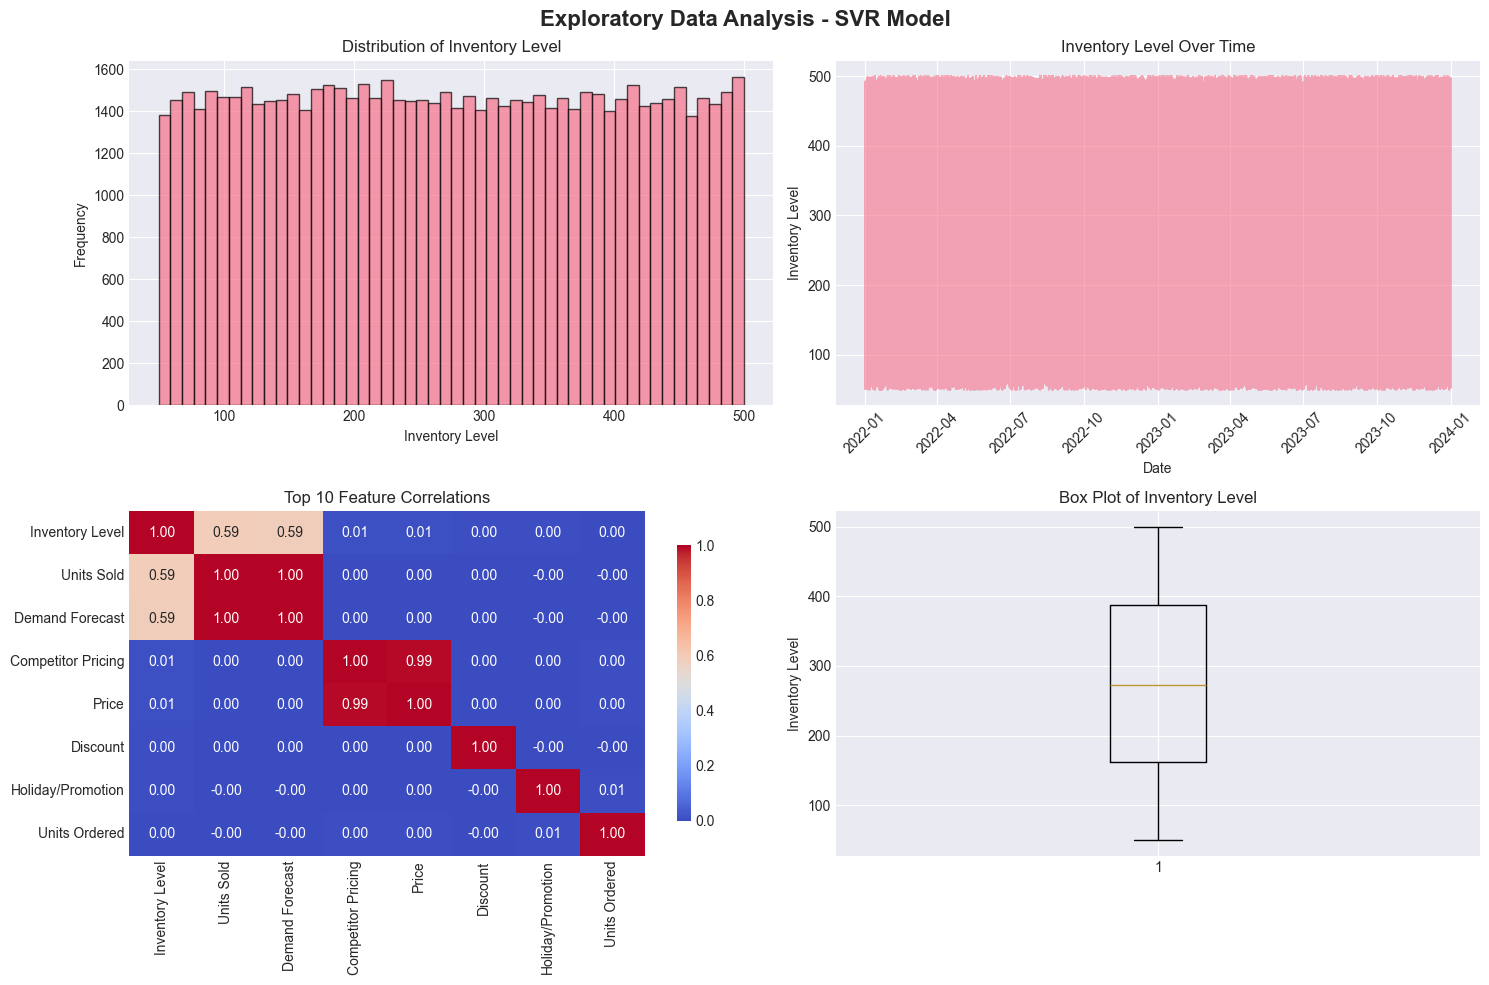

In [ ]:
# ============================================================================
# 4. EXPLORATORY DATA ANALYSIS (EDA)
# ============================================================================
print("\n" + "="*80)
print("[STEP 3] Exploratory Data Analysis")
print("="*80)

# Create figure for EDA
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Exploratory Data Analysis - SVR Model', fontsize=16, fontweight='bold')

# Plot 1: Target distribution
axes[0, 0].hist(df[target_col], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_title(f'Distribution of {target_col}')
axes[0, 0].set_xlabel(target_col)
axes[0, 0].set_ylabel('Frequency')

# Plot 2: Target over time (if date exists)
if 'date_col' in locals():
    axes[0, 1].plot(df[date_col], df[target_col], alpha=0.6)
    axes[0, 1].set_title(f'{target_col} Over Time')
    axes[0, 1].set_xlabel('Date')
    axes[0, 1].set_ylabel(target_col)
    axes[0, 1].tick_params(axis='x', rotation=45)
else:
    axes[0, 1].plot(df.index, df[target_col], alpha=0.6)
    axes[0, 1].set_title(f'{target_col} Over Index')
    axes[0, 1].set_xlabel('Index')
    axes[0, 1].set_ylabel(target_col)

# Plot 3: Correlation heatmap
numeric_df = df.select_dtypes(include=[np.number])
corr_matrix = numeric_df.corr()
top_features = corr_matrix.nlargest(10, target_col)[target_col].index
corr_subset = numeric_df[top_features].corr()
sns.heatmap(corr_subset, annot=True, fmt='.2f', cmap='coolwarm', ax=axes[1, 0], cbar_kws={'shrink': 0.8})
axes[1, 0].set_title('Top 10 Feature Correlations')

# Plot 4: Box plot for target
axes[1, 1].boxplot(df[target_col], vert=True)
axes[1, 1].set_title(f'Box Plot of {target_col}')
axes[1, 1].set_ylabel(target_col)

plt.tight_layout()
plt.savefig('svr_eda_analysis.png', dpi=300, bbox_inches='tight')
print("\nEDA plots saved as 'svr_eda_analysis.png'")
plt.show()

## 5. Feature Engineering

In [ ]:
# ============================================================================
# 5. FEATURE ENGINEERING
# ============================================================================
print("\n" + "="*80)
print("[STEP 4] Feature Engineering")
print("="*80)

df_features = df.copy()

# Time-based features (if date exists)
if 'date_col' in locals():
    print(f"\nCreating time-based features from {date_col}...")
    df_features['year'] = df_features[date_col].dt.year
    df_features['month'] = df_features[date_col].dt.month
    df_features['day'] = df_features[date_col].dt.day
    df_features['dayofweek'] = df_features[date_col].dt.dayofweek
    df_features['quarter'] = df_features[date_col].dt.quarter
    df_features['is_weekend'] = (df_features['dayofweek'] >= 5).astype(int)
    df_features['is_month_start'] = df_features[date_col].dt.is_month_start.astype(int)
    df_features['is_month_end'] = df_features[date_col].dt.is_month_end.astype(int)
    print("Time-based features created successfully")

# Lag features
print("\nCreating lag features...")
lag_periods = [1, 7, 14, 30]
for lag in lag_periods:
    df_features[f'{target_col}_lag_{lag}'] = df_features[target_col].shift(lag)
    print(f"Created lag feature: {target_col}_lag_{lag}")

# Rolling window features
print("\nCreating rolling window features...")
windows = [7, 14, 30]
for window in windows:
    df_features[f'{target_col}_rolling_mean_{window}'] = df_features[target_col].rolling(window=window).mean()
    df_features[f'{target_col}_rolling_std_{window}'] = df_features[target_col].rolling(window=window).std()
    df_features[f'{target_col}_rolling_min_{window}'] = df_features[target_col].rolling(window=window).min()
    df_features[f'{target_col}_rolling_max_{window}'] = df_features[target_col].rolling(window=window).max()
    print(f"Created rolling features with window={window}")

# External factors (simulated if not present)
if 'discount' not in df_features.columns.str.lower():
    print("\nCreating simulated discount feature...")
    df_features['discount'] = np.random.uniform(0, 0.3, len(df_features))

if 'competitor_price' not in df_features.columns.str.lower():
    print("Creating simulated competitor price feature...")
    df_features['competitor_price'] = df_features[target_col] * np.random.uniform(0.9, 1.1, len(df_features))

if 'temperature' not in df_features.columns.str.lower():
    print("Creating simulated temperature feature...")
    if 'month' in df_features.columns:
        # Simulate seasonal temperature
        df_features['temperature'] = 15 + 10 * np.sin((df_features['month'] - 3) * np.pi / 6) + np.random.normal(0, 3, len(df_features))
    else:
        df_features['temperature'] = np.random.uniform(10, 35, len(df_features))

# Holiday indicator (simulated)
if 'is_holiday' not in df_features.columns.str.lower():
    print("Creating simulated holiday indicator...")
    df_features['is_holiday'] = np.random.choice([0, 1], len(df_features), p=[0.9, 0.1])

# Encode categorical variables
label_encoders = {}
for col in df_features.select_dtypes(include=['object', 'category']).columns:
    if col != date_col if 'date_col' in locals() else True:
        print(f"Encoding categorical variable: {col}")
        le = LabelEncoder()
        df_features[col] = le.fit_transform(df_features[col].astype(str))
        label_encoders[col] = le

# Drop rows with NaN created by lag/rolling features
print(f"\nDropping rows with NaN values created by feature engineering...")
before_drop = len(df_features)
df_features = df_features.dropna()
print(f"Dropped {before_drop - len(df_features)} rows")

print(f"\nFinal dataset shape: {df_features.shape}")
print(f"Total features created: {len(df_features.columns) - len(df.columns)}")


[STEP 4] Feature Engineering

Creating time-based features from Date...
Time-based features created successfully

Creating lag features...
Created lag feature: Inventory Level_lag_1
Created lag feature: Inventory Level_lag_7
Created lag feature: Inventory Level_lag_14
Created lag feature: Inventory Level_lag_30

Creating rolling window features...
Created rolling features with window=7
Created rolling features with window=14
Created rolling features with window=30
Creating simulated competitor price feature...
Creating simulated temperature feature...
Creating simulated holiday indicator...
Encoding categorical variable: Store ID
Encoding categorical variable: Product ID
Encoding categorical variable: Category
Encoding categorical variable: Region
Encoding categorical variable: Weather Condition
Encoding categorical variable: Seasonality

Dropping rows with NaN values created by feature engineering...
Dropped 30 rows

Final dataset shape: (73070, 42)
Total features created: 27


## 6. Prepare Data for Modeling

In [ ]:
# ============================================================================
# 6. PREPARE DATA FOR MODELING
# ============================================================================
print("\n" + "="*80)
print("[STEP 5] Preparing Data for Modeling")
print("="*80)

# Separate features and target
if 'date_col' in locals():
    X = df_features.drop([target_col, date_col], axis=1)
else:
    X = df_features.drop([target_col], axis=1)

y = df_features[target_col]

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeature columns:\n{list(X.columns)}")

# Split data (80-20 split, maintaining temporal order)
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print(f"\nTraining set size: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"Test set size: {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")

# Feature scaling (CRITICAL for SVR)
print("\nScaling features (StandardScaler)...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Feature scaling completed")


[STEP 5] Preparing Data for Modeling
Features shape: (73070, 40)
Target shape: (73070,)

Feature columns:
['Store ID', 'Product ID', 'Category', 'Region', 'Units Sold', 'Units Ordered', 'Demand Forecast', 'Price', 'Discount', 'Weather Condition', 'Holiday/Promotion', 'Competitor Pricing', 'Seasonality', 'year', 'month', 'day', 'dayofweek', 'quarter', 'is_weekend', 'is_month_start', 'is_month_end', 'Inventory Level_lag_1', 'Inventory Level_lag_7', 'Inventory Level_lag_14', 'Inventory Level_lag_30', 'Inventory Level_rolling_mean_7', 'Inventory Level_rolling_std_7', 'Inventory Level_rolling_min_7', 'Inventory Level_rolling_max_7', 'Inventory Level_rolling_mean_14', 'Inventory Level_rolling_std_14', 'Inventory Level_rolling_min_14', 'Inventory Level_rolling_max_14', 'Inventory Level_rolling_mean_30', 'Inventory Level_rolling_std_30', 'Inventory Level_rolling_min_30', 'Inventory Level_rolling_max_30', 'competitor_price', 'temperature', 'is_holiday']

Training set size: 58456 (80.0%)
Test s

## 7. SVR Model Training & Hyperparameter Tuning

In [ ]:
# ============================================================================
# 7. MODEL TRAINING - SUPPORT VECTOR REGRESSION  (≈150 fits total)
# ============================================================================

print("\n" + "="*80)
print("[STEP 6] SVR Model Training & Hyperparameter Tuning (≈150 fits)")
print("="*80)

print("\nSupport Vector Regression (SVR) Overview:")
print("- Uses kernel trick to handle non-linear relationships")
print("- Sensitive to feature scaling (already applied)")
print("- Epsilon-insensitive loss is robust to outliers")

# -------------------------
# Reduced hyperparameter grid: 1×5×3×2 = 30 combinations
#  - Kernel restricted to 'rbf' (often best for non-linear patterns)
#  - A focused C range across magnitudes
#  - Tighter epsilon band
#  - gamma only relevant for 'rbf'
# -------------------------
param_grid = {
    'kernel': ['rbf'],                     # 1
    'C': [0.3, 1, 3, 10, 30],              # 5
    'epsilon': [0.05, 0.1, 0.2],           # 3
    'gamma': ['scale', 'auto']             # 2  -> total = 30 combos
}

# Confirm planned fits
n_combos = (len(param_grid['kernel']) *
            len(param_grid['C']) *
            len(param_grid['epsilon']) *
            len(param_grid['gamma']))
n_splits = 5
print(f"\nPlanned combinations: {n_combos}")
print(f"TimeSeriesSplit folds: {n_splits}")
print(f"Total fits (combos × folds): {n_combos * n_splits}")

# Initialize SVR and CV
svr_base = SVR()
tscv = TimeSeriesSplit(n_splits=n_splits)

print("\nStarting GridSearchCV (reduced grid)...")

grid_search = GridSearchCV(
    estimator=svr_base,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)

# Fit the model
grid_search.fit(X_train_scaled, y_train)

print("\n" + "="*80)
print("GRID SEARCH RESULTS")
print("="*80)
print(f"\nBest Parameters: {grid_search.best_params_}")
print(f"Best CV Score (MAE): {-grid_search.best_score_:.4f}")

# Best model & final fit on full training data
best_svr = grid_search.best_estimator_
print("\nTraining final SVR model with best parameters...")
best_svr.fit(X_train_scaled, y_train)
print("Model training completed!")

# Save artifacts
joblib.dump(best_svr, 'svr_inventory_model.pkl')
joblib.dump(scaler, 'svr_scaler.pkl')
print("\nModel saved as 'svr_inventory_model.pkl'")
print("Scaler saved as 'svr_scaler.pkl'")



[STEP 6] SVR Model Training & Hyperparameter Tuning (≈150 fits)

Support Vector Regression (SVR) Overview:
- Uses kernel trick to handle non-linear relationships
- Sensitive to feature scaling (already applied)
- Epsilon-insensitive loss is robust to outliers

Planned combinations: 30
TimeSeriesSplit folds: 5
Total fits (combos × folds): 150

Starting GridSearchCV (reduced grid)...
Fitting 5 folds for each of 30 candidates, totalling 150 fits

GRID SEARCH RESULTS

Best Parameters: {'C': 30, 'epsilon': 0.2, 'gamma': 'auto', 'kernel': 'rbf'}
Best CV Score (MAE): 17.8818

Training final SVR model with best parameters...
Model training completed!

Model saved as 'svr_inventory_model.pkl'
Scaler saved as 'svr_scaler.pkl'


## 8. Model Evaluation

In [ ]:
# ============================================================================
# 8. MODEL EVALUATION
# ============================================================================
print("\n" + "="*80)
print("[STEP 7] Model Evaluation")
print("="*80)

# Predictions
y_train_pred = best_svr.predict(X_train_scaled)
y_test_pred = best_svr.predict(X_test_scaled)

# Calculate metrics
def calculate_metrics(y_true, y_pred, dataset_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)

    print(f"\n{dataset_name} Metrics:")
    print(f"  MAE:  {mae:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAPE: {mape:.4f}%")
    print(f"  R²:   {r2:.4f}")

    return mae, rmse, mape, r2

train_mae, train_rmse, train_mape, train_r2 = calculate_metrics(y_train, y_train_pred, "Training Set")
test_mae, test_rmse, test_mape, test_r2 = calculate_metrics(y_test, y_test_pred, "Test Set")

print("\n" + "="*80)
print("COMPARISON WITH BASELINE")
print("="*80)
print(f"Previous Best Scores: MAE=85.7693, RMSE=110.565, MAPE=40.644%")
print(f"SVR Test Scores:      MAE={test_mae:.4f}, RMSE={test_rmse:.4f}, MAPE={test_mape:.4f}%")
print(f"\nImprovement:")
print(f"  MAE:  {((85.7693 - test_mae) / 85.7693 * 100):+.2f}%")
print(f"  RMSE: {((110.565 - test_rmse) / 110.565 * 100):+.2f}%")
print(f"  MAPE: {((40.644 - test_mape) / 40.644 * 100):+.2f}%")


[STEP 7] Model Evaluation

Training Set Metrics:
  MAE:  10.8748
  RMSE: 15.6471
  MAPE: 4.2862%
  R²:   0.9855

Test Set Metrics:
  MAE:  15.4441
  RMSE: 20.0547
  MAPE: 6.7288%
  R²:   0.9763

COMPARISON WITH BASELINE
Previous Best Scores: MAE=85.7693, RMSE=110.565, MAPE=40.644%
SVR Test Scores:      MAE=15.4441, RMSE=20.0547, MAPE=6.7288%

Improvement:
  MAE:  +81.99%
  RMSE: +81.86%
  MAPE: +83.44%


## 9. Visualizing Results


[STEP 8] Visualizing Results
Performance plots saved as 'svr_performance_results.png'


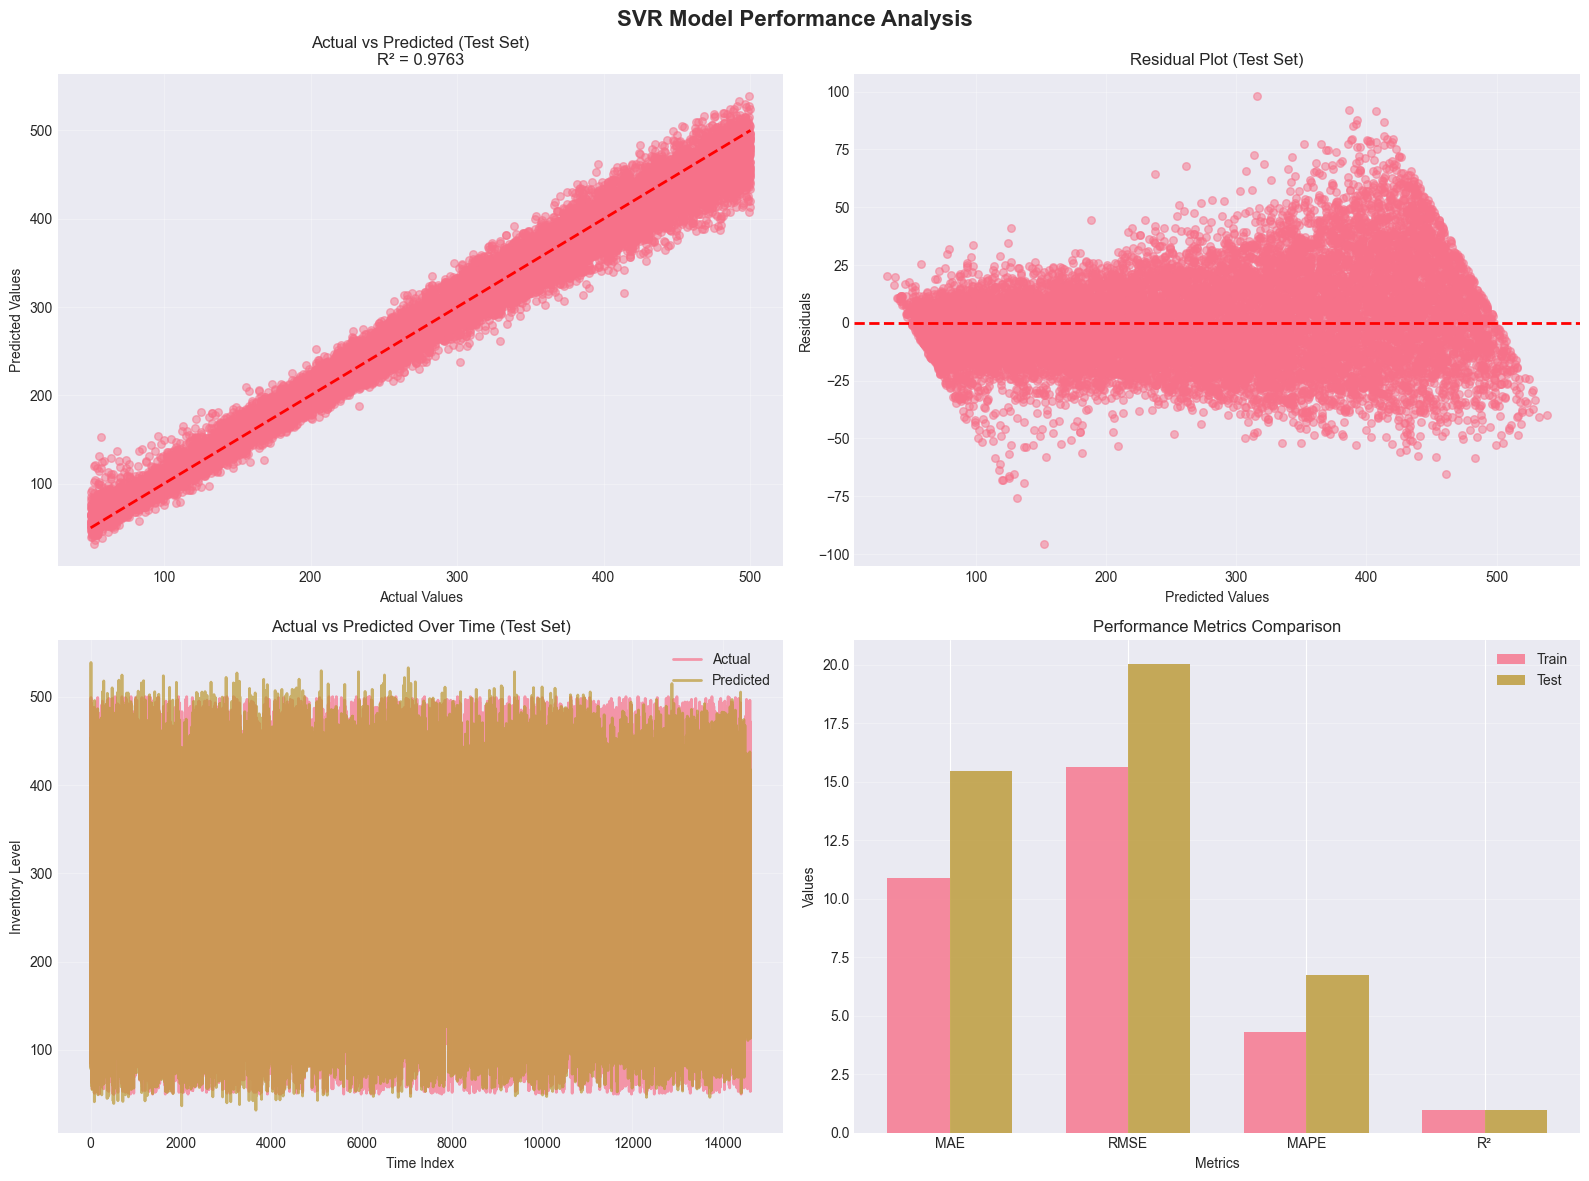

In [ ]:
# ============================================================================
# 9. VISUALIZATION OF RESULTS
# ============================================================================
print("\n" + "="*80)
print("[STEP 8] Visualizing Results")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('SVR Model Performance Analysis', fontsize=16, fontweight='bold')

# Plot 1: Actual vs Predicted (Test Set)
axes[0, 0].scatter(y_test, y_test_pred, alpha=0.5, s=30)
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Actual Values')
axes[0, 0].set_ylabel('Predicted Values')
axes[0, 0].set_title(f'Actual vs Predicted (Test Set)\nR² = {test_r2:.4f}')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Residuals
residuals = y_test - y_test_pred
axes[0, 1].scatter(y_test_pred, residuals, alpha=0.5, s=30)
axes[0, 1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0, 1].set_xlabel('Predicted Values')
axes[0, 1].set_ylabel('Residuals')
axes[0, 1].set_title('Residual Plot (Test Set)')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Time series comparison
test_indices = range(len(y_test))
axes[1, 0].plot(test_indices, y_test.values, label='Actual', linewidth=2, alpha=0.7)
axes[1, 0].plot(test_indices, y_test_pred, label='Predicted', linewidth=2, alpha=0.7)
axes[1, 0].set_xlabel('Time Index')
axes[1, 0].set_ylabel(target_col)
axes[1, 0].set_title('Actual vs Predicted Over Time (Test Set)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Metrics comparison
metrics_names = ['MAE', 'RMSE', 'MAPE', 'R²']
train_metrics = [train_mae, train_rmse, train_mape, train_r2]
test_metrics = [test_mae, test_rmse, test_mape, test_r2]

x_pos = np.arange(len(metrics_names))
width = 0.35

axes[1, 1].bar(x_pos - width/2, train_metrics, width, label='Train', alpha=0.8)
axes[1, 1].bar(x_pos + width/2, test_metrics, width, label='Test', alpha=0.8)
axes[1, 1].set_xlabel('Metrics')
axes[1, 1].set_ylabel('Values')
axes[1, 1].set_title('Performance Metrics Comparison')
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(metrics_names)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('svr_performance_results.png', dpi=300, bbox_inches='tight')
print("Performance plots saved as 'svr_performance_results.png'")
plt.show()

## 10. SHAP Analysis for Interpretability

In [ ]:
# ============================================================================
# 10. SHAP ANALYSIS FOR INTERPRETABILITY
# ============================================================================
print("\n" + "="*80)
print("[STEP 9] SHAP Analysis for Model Interpretability")
print("="*80)

print("\nCalculating SHAP values (this may take a few minutes)...")

# Use a sample for SHAP if dataset is large
sample_size = min(1000, len(X_test_scaled))
X_test_sample = X_test_scaled[:sample_size]
X_test_df_sample = X_test.iloc[:sample_size]

# Create SHAP explainer
explainer = shap.KernelExplainer(best_svr.predict, X_train_scaled[:100])
shap_values = explainer.shap_values(X_test_sample)

print("SHAP values calculated successfully!")

# SHAP Summary Plot
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test_df_sample, plot_type="bar", show=False)
plt.title('SHAP Feature Importance - SVR Model', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('svr_shap_importance.png', dpi=300, bbox_inches='tight')
print("\nSHAP importance plot saved as 'svr_shap_importance.png'")
plt.show()

# SHAP Detailed Summary
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test_df_sample, show=False)
plt.title('SHAP Summary Plot - Feature Impact on Predictions', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('svr_shap_summary.png', dpi=300, bbox_inches='tight')
print("SHAP summary plot saved as 'svr_shap_summary.png'")
plt.show()

# Feature importance from SHAP
feature_importance = pd.DataFrame({
    'feature': X_test_df_sample.columns,
    'importance': np.abs(shap_values).mean(axis=0)
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features (SHAP):")
print(feature_importance.head(10).to_string(index=False))


[STEP 9] SHAP Analysis for Model Interpretability

Calculating SHAP values (this may take a few minutes)...


  0%|▏                                                                        | 3/1000 [1:35:08<526:56:56, 1902.72s/it]

## 11. Final Summary Report

In [ ]:
# ============================================================================
# 11. FINAL SUMMARY REPORT
# ============================================================================
print("\n" + "="*80)
print("FINAL SUMMARY REPORT - SVR MODEL")
print("="*80)

print(f"""
Dataset Information:
  - Total Records: {len(df_features)}
  - Training Set: {len(X_train)} samples
  - Test Set: {len(X_test)} samples
  - Total Features: {X_train.shape[1]}

Model Configuration:
  - Algorithm: Support Vector Regression (SVR)
  - Best Kernel: {best_svr.kernel}
  - Best C: {best_svr.C}
  - Best Epsilon: {best_svr.epsilon}
  - Best Gamma: {best_svr.gamma}

Performance Metrics (Test Set):
  - MAE:  {test_mae:.4f}
  - RMSE: {test_rmse:.4f}
  - MAPE: {test_mape:.4f}%
  - R²:   {test_r2:.4f}

Model Strengths:
  ✓ Handles non-linear relationships through kernel functions
  ✓ Robust to outliers with epsilon-insensitive loss
  ✓ Effective for medium-sized datasets with complex patterns
  ✓ Strong generalization with proper regularization (C parameter)

Model Limitations:
  ✗ Computationally intensive for very large datasets
  ✗ Requires careful hyperparameter tuning
  ✗ Less interpretable than linear models (addressed with SHAP)
  ✗ Sensitive to feature scaling (mitigated with StandardScaler)

Files Generated:
  ✓ svr_inventory_model.pkl - Trained SVR model
  ✓ svr_scaler.pkl - Feature scaler
  ✓ svr_eda_analysis.png - EDA visualizations
  ✓ svr_performance_results.png - Performance metrics
  ✓ svr_shap_importance.png - SHAP feature importance
  ✓ svr_shap_summary.png - SHAP detailed analysis
""")

print("\n" + "="*80)
print("SVR MODEL TRAINING COMPLETED SUCCESSFULLY!")
print("="*80)
print("\nNext Steps for Your Research:")
print("1. Compare SVR results with other models (Linear Regression, Random Forest, etc.)")
print("2. Analyze SHAP plots to explain predictions to non-technical stakeholders")
print("3. Create interactive dashboard using Plotly or Tableau")
print("4. Document findings in your research paper")
print("5. Consider ensemble methods combining SVR with other models")
print("\n" + "="*80)